# A convolutional neural network-based classifier for the MNIST handwritten digit dataset

Let's start by importing some packages we need.

In [0]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.cmap'] = 'Greys'

import numpy as np
np.set_printoptions(suppress=True)
np.set_printoptions(precision=2)

## Getting a feel for the data

MNIST is a dataset that contains 70,000 labelled images of handwritten digits that look like the following.

![MNIST Data Sample](https://github.com/sbanerjee2020/NST/blob/master/images/mnist-sample.png?raw=true "MNIST Data Sample")

We're going to train a linear classifier on a part of this data set, and test it against another portion of the data set to see how well we did.

The TensorFlow tutorial comes with a handy loader for this dataset.

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


The loader even handily splits the data set into three parts:

* A training set (55000 examples) used to train the model
* A validation set (5000 examples) used to optimise hyperparameters (not shown today)
* A test set (10000 examples) used to gauge the accuracy of the trained model

The images are greyscale and each 28 pixels wide by 28 pixels tall, and this is stored as an array of length 784.

The labels are a *one hot* vector of length 10, meaning it is a vector of all zeros except at the location that corresponds to the label it's referring to. E.g. An image with a label `3` will be represented as `(0, 0, 0, 1, 0, 0, 0, 0, 0, 0)`.


In [3]:
print mnist.train.images.shape
print mnist.train.labels.shape

(55000, 784)
(55000, 10)


In [4]:
print mnist.test.images.shape
print mnist.test.labels.shape

(10000, 784)
(10000, 10)


We can get a better sense for one of these examples by visualising the image and looking at the label.

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


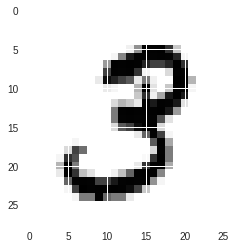

In [5]:
example_image = mnist.train.images[1]
example_image_reshaped = example_image.reshape((28, 28)) # Can't render a line of 784 numbers
example_label = mnist.train.labels[1]

print example_label
plt.imshow(example_image_reshaped)

## Setting up a score function, loss function and optimisation algorithm

Now that we have a better sense of the dataset we're working with, let's move onto the machine learning bits.

First, we setup some placeholders to hold batches of this training data for when we learn our model. The reason why we work in batches is that it's easier on memory than holding the entire set. And it's this notion of working with (random) batches of input rather than the entire set that moves us from the realm of *Gradient Descent* that we saw earlier, to *Stochastic Gradient Descent* that we have here.

In [0]:
x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10])

In abstract notation, the models we've seen so far are:

1. `Linear: Input -> FC -> Softmax -> Loss`
2. `Neural Network: Input -> FC -> ReLU -> FC -> Softmax -> Loss`

In this notation, the model we're going to work out in this example is:

`Input -> CONV (-> ReLU -> Pool) -> FC -> ReLU -> FC -> Softmax -> Loss`

In [0]:
# Define some helper functions to ease the definition of the model
def weight_variable(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

def bias_variable(shape):
    return tf.Variable(tf.constant(0.1, shape=shape))

def conv(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def pool(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


# A score function (model) involving some layers

# Reshape the input to look like a volume (Input)
x_image = tf.reshape(x, [-1, 28, 28, 1])

# A convolutional layer (CONV -> RELU -> POOL)
W_conv = weight_variable([5, 5, 1, 32])
b_conv = bias_variable([32])
h_conv = tf.nn.relu(conv(x_image, W_conv) + b_conv)
h_pool = pool(h_conv)

# A densely connected layer (FC)
W_fc1 = weight_variable([14*14*32, 1024])
b_fc1 = bias_variable([1024])
h_pool_flat = tf.reshape(h_pool, [-1, 14*14*32])
h_fc1 = tf.nn.relu(tf.matmul(h_pool_flat, W_fc1) + b_fc1)

# Another densely connected layer (for "readout") (FC)
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
y = tf.matmul(h_fc1, W_fc2) + b_fc2

We define our loss function to measure how poorly this model performs on images with known labels. We use the a specific form called the [cross entropy loss](https://jamesmccaffrey.wordpress.com/2013/11/05/why-you-should-use-cross-entropy-error-instead-of-classification-error-or-mean-squared-error-for-neural-network-classifier-training/).

In [8]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



Using the magic of blackbox optimisation algorithms provided by TensorFlow, we can define a single step of the [Adam optimiser](https://arxiv.org/abs/1412.6980) (to improve our parameters for our score function and reduce the loss) in one line of code.

In [0]:
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

## Training the model

The way TensorFlow works, we haven't really executed any of the code above in the classic sense. All we've done is defined what's called the computational graph.

Now we go ahead and initialise a session to actually train the model and evaluate its performance.

In [0]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

We train the model iteratively for 20000 steps, loading a batch of example images each time.

In [0]:
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [12]:
for i in range(2000):
    batch = mnist.train.next_batch(50)
    if i%100 == 0:
        train_accuracy = accuracy.eval(session=sess, feed_dict={
            x:batch[0], y_: batch[1]})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(session=sess, feed_dict={x: batch[0], y_: batch[1]})

step 0, training accuracy 0.04
step 100, training accuracy 0.88
step 200, training accuracy 0.92
step 300, training accuracy 0.82
step 400, training accuracy 0.86
step 500, training accuracy 0.9
step 600, training accuracy 0.92
step 700, training accuracy 0.96
step 800, training accuracy 0.94
step 900, training accuracy 0.94
step 1000, training accuracy 0.96
step 1100, training accuracy 0.98
step 1200, training accuracy 0.92
step 1300, training accuracy 0.98
step 1400, training accuracy 0.98
step 1500, training accuracy 1
step 1600, training accuracy 0.94
step 1700, training accuracy 0.98
step 1800, training accuracy 0.94
step 1900, training accuracy 1


## Verifying the results

At this point, our model is trained. And we can deterime in the *accuracy* by passing in all the test images and labels, figuring out our own labels, and averaging out the results.

In [13]:
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9726


## Extension: Reproduce the Deep MNIST for Experts tutorial

The model we used in this exercise,

`Input -> CONV (-> ReLU -> Pool) -> FC -> ReLU -> FC -> Softmax -> Loss`

is a simplified version of the model used in the the [Deep MNIST for Experts](https://www.tensorflow.org/get_started/mnist/pros) tutorial on the TensorFlow website:

`Input -> CONV (-> RELU -> Pool) -> CONV (-> RELU -> Pool) -> FC -> ReLU -> Dropout -> FC -> Softmax -> Loss`

You're now in a greate place to extend this code to their mode, further upping the classification accuracy!